In [215]:
import pandas as pd
from dotenv import load_dotenv
import os
load_dotenv()

path_data = os.getenv("path_to_data")

In [216]:
df = pd.read_csv("../Daten/masterdata_2024.csv", index_col=1)
df.index = pd.to_datetime(df.index, errors="coerce")  

In [217]:
df = df.applymap(lambda x: x if pd.api.types.is_number(x) else 0)

C:\Users\Dome Arbeit\AppData\Local\Temp\ipykernel_21276\3812220186.py:1: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: x if pd.api.types.is_number(x) else 0)


In [218]:
df = df.apply(pd.to_numeric, errors='ignore')

C:\Users\Dome Arbeit\AppData\Local\Temp\ipykernel_21276\1277559549.py:1: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df = df.apply(pd.to_numeric, errors='ignore')


In [219]:
try:
    df.drop(columns=["Unnamed: 0"], inplace=True)
except:
    ...

In [220]:
bacteria_cols = ["ecoli", "entro"]
bacteria_df = df[df[bacteria_cols].notna().any(axis=1)].copy()

weather_cols = df.select_dtypes(include="number").columns.difference(bacteria_cols)
weather_df  = df[weather_cols].copy()


In [221]:
def aggregate_data(ts, weather, window_days=3, funcs=("mean", "sum")):
    mask   = (weather.index >= ts - pd.Timedelta(days=window_days)) & (weather.index < ts)
    agg    = weather.loc[mask].agg(funcs)            # Multi-Index columns
    flat   = agg.stack().to_frame().T                # flatten to single row
    flat.columns = [f"{func}_{col}" for func, col in flat.columns]
    return flat


In [222]:
rows = []

for ts, row in bacteria_df.iterrows():
    if pd.isna(ts):          # skip bad timestamps
        continue
    agg_row = aggregate_data(ts, weather_df)
    agg_row["timestamp"] = ts
    agg_row[bacteria_cols] = row[bacteria_cols].values
    rows.append(agg_row)

In [223]:
final_df = pd.concat(rows, ignore_index=True)

# put timestamp + bacteria first
leading = ["timestamp"] + bacteria_cols
final_df = final_df[leading + [c for c in final_df.columns if c not in leading]]

In [224]:
final_df.fillna(0, inplace = True)

In [225]:
final_df["ecoli"] = final_df["ecoli"].astype("float32")

In [226]:
import re

# Define a mapping from JSON special characters to UTF-8 alternatives
json_to_utf8 = {
    '"': '',   # left double quotation mark
    "'": '',   # left single quotation mark
    '{': '',  # fullwidth left curly bracket
    '}': '',  # fullwidth right curly bracket
    '[': '',  # left black lenticular bracket
    ']': '',  # right black lenticular bracket
    ':': '',  # fullwidth colon
    ',': '',  # fullwidth comma
    '\\': '', # fullwidth reverse solidus
    " ": ""
}

def replace_json_chars(col):
    # Replace each JSON character with its UTF-8 alternative
    for k, v in json_to_utf8.items():
        col = col.replace(k, v)
    return col

final_df.columns = [replace_json_chars(col) for col in final_df.columns]

[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000440 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 262
[LightGBM] [Info] Number of data points in the train set: 18, number of used features: 52
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Info] Start training from score 3036.666667
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM]

c:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


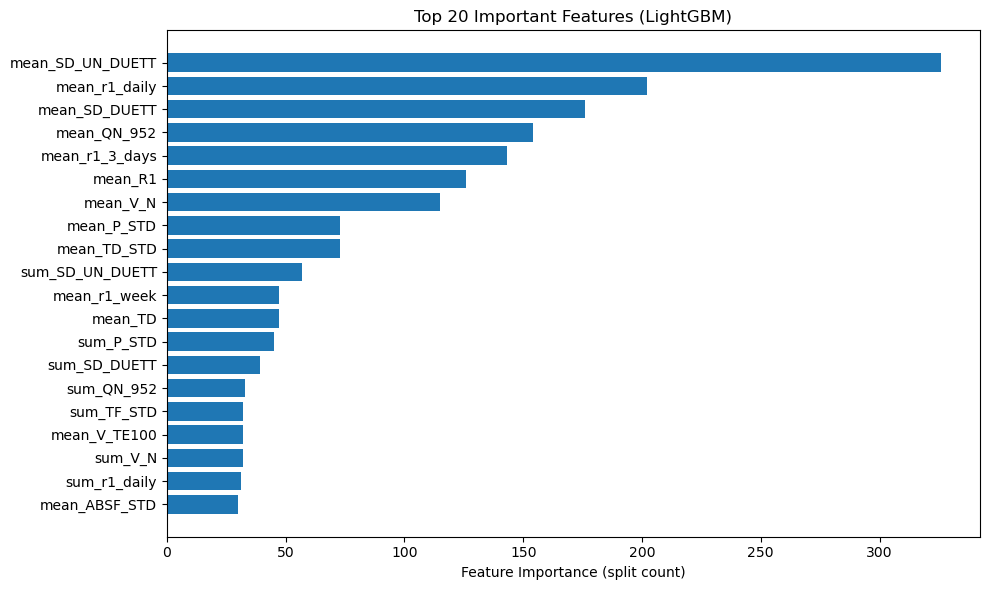

In [227]:
# ---------------------------------------------------------------
# LightGBM regression on `final_df`
#   • target:  ecoli
#   • drop:    entro  (and timestamp)
# ---------------------------------------------------------------
import pandas as pd
import lightgbm as lgb
from lightgbm import LGBMRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
df_model = final_df.dropna(subset=['ecoli']).copy()

X = df_model.drop(columns=['ecoli', 'entro', 'timestamp'])
y = df_model['ecoli']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42
)

# ----------------------------------------------------------------
# 3.  fit LightGBM -----------------------------------------------
# ----------------------------------------------------------------
lgb_params = dict(
    n_estimators=1000,
    learning_rate=0.05,
    num_leaves=31,
    subsample=0.8,
    colsample_bytree=0.8,
    min_data_in_leaf=5,          # lower from default (20)
    min_data_in_bin=5,           # lower from default (255)
    random_state=42,
    n_jobs=-1,
)


model = LGBMRegressor(**lgb_params)

model.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    eval_metric="rmse")

# ----------------------------------------------------------------
# 4.  evaluation --------------------------------------------------
# ----------------------------------------------------------------
y_pred = model.predict(X_test)
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2   = r2_score(y_test, y_pred)

print(f"RMSE: {rmse:.3f}")
print(f"R²  : {r2:.3f}")

# ----------------------------------------------------------------
# 5.  feature importance -----------------------------------------
# ----------------------------------------------------------------
import pandas as pd
import matplotlib.pyplot as plt

# Get feature importances and build a DataFrame
feature_importance_df = pd.DataFrame({
    'feature': X.columns,
    'importance': model.feature_importances_  # This is "split" importance by default
})

# Sort by importance
feature_importance_df = feature_importance_df.sort_values(by='importance', ascending=False)

# Plot top N features
top_n = 20
top_features = feature_importance_df.head(top_n)

plt.figure(figsize=(10, 6))
plt.barh(top_features['feature'], top_features['importance'])
plt.xlabel("Feature Importance (split count)")
plt.title(f"Top {top_n} Important Features (LightGBM)")
plt.gca().invert_yaxis()  # Most important at top
plt.tight_layout()
plt.show()


Final shape after cleaning: (23, 58)
⚠️ LightGBM failed, falling back to RandomForest.
LGBMRegressor.fit() got an unexpected keyword argument 'early_stopping_rounds'

✅ Evaluation:
RMSE: 3171.69
R²  : -0.431


c:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


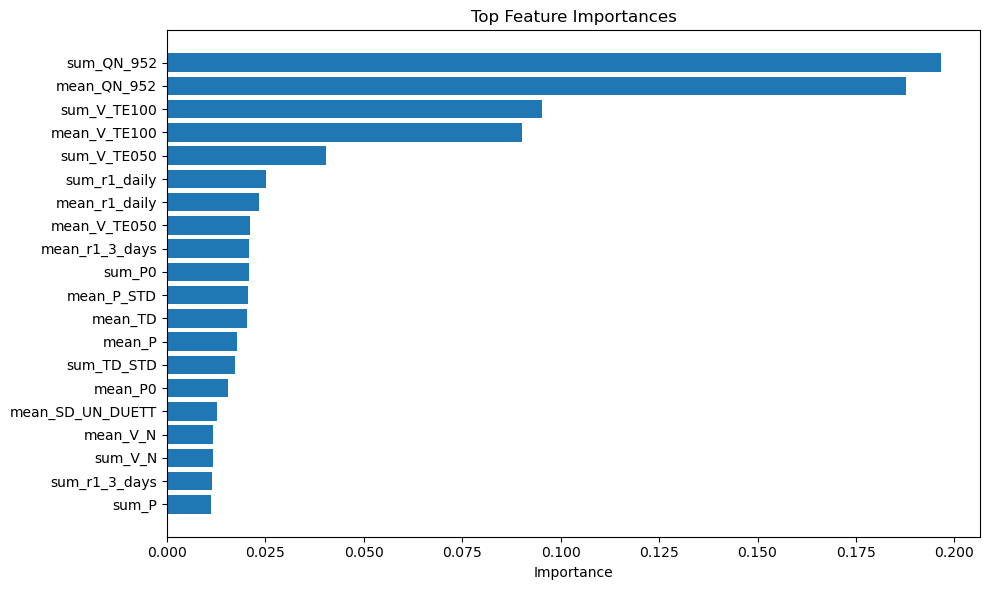

In [228]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor

# ------------------------------------------------------------------
# 1. Prepare data --------------------------------------------------
# ------------------------------------------------------------------
# df = pd.read_csv("bacteria_weather_ready.csv", parse_dates=['timestamp'])  # if loading from file

df_model = final_df.drop(columns=["entro", "timestamp"]).copy()
df_model = df_model.dropna(subset=["ecoli"])  # must have target

X_raw = df_model.drop(columns=["ecoli"])
y = df_model["ecoli"]

# ------------------------------------------------------------------
# 2. Impute missing features ---------------------------------------
# ------------------------------------------------------------------
imputer = SimpleImputer(strategy="mean")
X_imputed = pd.DataFrame(imputer.fit_transform(X_raw), columns=X_raw.columns)

# ------------------------------------------------------------------
# 3. Drop constant / near-constant features ------------------------
# ------------------------------------------------------------------
selector = VarianceThreshold(threshold=0.01)
X_reduced = pd.DataFrame(selector.fit_transform(X_imputed),
                         columns=X_imputed.columns[selector.get_support()])

print(f"Final shape after cleaning: {X_reduced.shape}")

# ------------------------------------------------------------------
# 4. Train-test split ----------------------------------------------
# ------------------------------------------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X_reduced, y, test_size=0.2, random_state=42
)

# ------------------------------------------------------------------
# 5. LightGBM Model -----------------------------------------------
# ------------------------------------------------------------------
try:
    model = LGBMRegressor(
        n_estimators=1000,
        learning_rate=0.05,
        num_leaves=31,
        subsample=0.8,
        colsample_bytree=0.8,
        min_data_in_leaf=5,
        min_data_in_bin=5,
        random_state=42,
        n_jobs=-1,
    )

    model.fit(
        X_train, y_train,
        eval_set=[(X_test, y_test)],
        eval_metric="rmse",
        early_stopping_rounds=50,
        verbose=100
    )

except Exception as e:
    print("⚠️ LightGBM failed, falling back to RandomForest.")
    print(e)
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)

# ------------------------------------------------------------------
# 6. Evaluation ----------------------------------------------------
# ------------------------------------------------------------------
y_pred = model.predict(X_test)
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2   = r2_score(y_test, y_pred)

print(f"\n✅ Evaluation:")
print(f"RMSE: {rmse:.2f}")
print(f"R²  : {r2:.3f}")

# ------------------------------------------------------------------
# 7. Feature Importance --------------------------------------------
# ------------------------------------------------------------------
importances = model.feature_importances_
fi_df = pd.DataFrame({
    "feature": X_reduced.columns,
    "importance": importances
}).sort_values(by="importance", ascending=False)

top_n = 20
top_features = fi_df.head(top_n)

plt.figure(figsize=(10, 6))
plt.barh(top_features["feature"], top_features["importance"])
plt.title("Top Feature Importances")
plt.xlabel("Importance")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()
